# Project Name: Hypothesis Testing & Analysis with Ecommerce Data

<br> Bonnie Ma
<br> https://github.com/bonniema

Statistical Methods Used: Central Limit Thereom, Independent T-Test, Welch's T-Test, Mann Whitney U Test, ANOVA, KS Test, Levene's Test


## Overview
<br>1.[Objective & Background](#001)
<br>2.[Import Libraries & Defining Functions](#002)
<br>3.[Question #1: Discount's Impact on Quantity per order](#003)
<br>4.[Question #2: Discount's Impact on Category Revenue](#004)
<br>5.[Question #3: Regional Performance](#005)
<br>6.[Question #4: Seasonal Performance](#006)
<br>7.[Summary and Next Steps](#007)

## 1. Background & Objective
<a id="001"></a>

### 1.1 Objective

Use Northwind Database to get the data needed to perform a statistical analysis (hypothesis testing) and answer following questions:
<br>
<br>1) Does discount amount have a statistically significant effect on the quantity of product in an order? If so, at what level(s) of discount?
<br>2) Does discount amount have a statistically significant effect on the revenue of any category in an order? If so, what category are mostly impacted? 
<br>3) Does each region generate the same average order revenue? 
<br>4) Does seasonality have a significant impact on the revenue of any category in an order?

### 1.2 Data Overview

>**Northwind Database**
<br> The Northwind database is a sample database used by Microsoft to demonstrate the features of some of its products. The database contains the sales data for Northwind Traders, a fictitious specialty foods export/import company.
<br>
<br>
>**Table Structure**
<img src="images/Northwind_ERD_updated.png">


### 1.3 Data Science Process

<br>- Data Exploration
<br>- Hypothesis Development
<br>- Hypothesis Test
<br>- Interpret the results

## 2. Import librabries & Defining Functions
<a id="002"></a>

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm


%matplotlib inline


In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
cur.execute(
"""
SELECT name from sqlite_master
WHERE type="table";
""")

In [5]:
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

## Define Functions

### SQL to Dataframe

In [6]:
def sql_with_cols(query,cursor=cur):
  
  result = cursor.execute(query).fetchall()
  cols = tuple([description[0] for description in cur.description])
  
  full_result = (cols, result[:])
  return full_result

def df_sql(query, cursor=cur):
    cols, result_data = sql_with_cols(query, cursor)
    return pd.DataFrame(data=result_data, columns=cols)

### Cohen's D

Cohen’s d is one of the most common ways to measure effect size. Effect size tells us how big the difference is. As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable. 

The basic formula to calculate Cohen’s $d$ is:

> **$d$ = effect size (difference of means) / pooled standard deviation**

The denominator is the **standardiser**, and it is important to select the most appropriate one for a given dataset. The pooled standard deviation is the average spread of all data points around their group mean (not the overall mean). 

Guidelines
<blockquote>
    Small effect = 0.2
    <br>Medium Effect = 0.5
    <br>Large Effect = 0.8
</blockquote>

In [7]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

### Independent Two Sample T-Test

Assumption: 
- **Assumption of Independence**: two samples are independent observations
- **Assumption of Normality**: if sample size is smaller than 25, the dependent variable must follow a normal distribution in the population 
- **Assumption of Homogeneity of Variance**: if the sample size are unequal, the standard deviation of the dependent variable must be equal in both populations


In [8]:
#Two sample T-Test
def two_sample_ttest(a, b, alpha=0.05):
    t, pvalue = stats.ttest_ind(a,b)
    print("P-value is " + str(pvalue))
    if pvalue >= alpha:
        return "Fail to reject the null."
    else:
        return "Reject the null hypothesis."

### Welch's T Test for Samples with different variances

Assumption of normality still hold true. Welch's T Test is more robust than Student's T-Test and maintains Type I error rates close to nominal for unequal variances and for unequal sample sizes under normality. 

In [9]:
#Welch's T Test for Samples with different variances
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """
    
    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    t = np.abs(numerator/denominator)
    
    return t

def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    df = numerator/denominator
    
    return round(df, 0)
   
     #Return the degrees of freedom

def welch_t_p_value(a, b, two_sided=False):
    
    t = welch_t(a,b)
    df = welch_df(a,b)
    
    p = 1 - stats.t.cdf(t, df)
    
    if two_sided:
        return 2*p
    else:
        return p
    

### Non-Parametric Mann-Whitney Test (2 sample version of T-Test)

The dependent variable should be measured on an ordinal scale or a continuous scale.
The independent variable should be two independent, categorical groups.
Observations should be independent. In other words, there should be no relationship between the two groups or within each group.
Observations are not normally distributed. However, they should follow the same shape (i.e. both are bell-shaped and skewed left).

In [165]:
def mannwhitney_test(a, b, alpha=0.05):
    t, pvalue = stats.mannwhitneyu(a,b)
    print("P-value is " + str(pvalue))
    if pvalue >= alpha:
        return "Fail to reject the null."
    else:
        return "Reject the null hypothesis."
        

### Test for Normality

In [11]:
from scipy import stats

In [12]:
def normality_test(data, alpha=0.05):
    
    d, pvalue = stats.kstest(data, 'norm')
    
    if pvalue >= alpha:
        print("Fail to reject the null. The sample is normally distributed!")
    else:
        print("Reject the null. The sample is not normally distributed at the significance level")
        
    

### Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
<a id="003"></a>

### 1.1 Hypothesis Statement 

$H_0$: Discount amount does **not** have a significant effect on the quantity of a product in an order<br>

$H_a$: Discount amount does have a significant effect on the quantity of a product in an order<br>

Significant level = 95%, alpha = 0.05

### 1.2 Data Exploration

In [13]:
discount = df_sql(
"""
SELECT * FROM OrderDetail

""")

Different levels of discount can be categoried into 5 levels based on frequency: 0%, 5%, 10%, 15%, 20%, 25%.
First we examine **no discount at all** with **at least some level of discount**; Secondly, we can run Anova tests on different levels and understand which level has the most impact.

In [14]:
discount.groupby("Discount")['Quantity'].count()

Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Quantity, dtype: int64

In [15]:
df = df_sql("""
SELECT OrderId, Sum(Quantity) as quantity, Avg(Discount) as avg_dis FROM OrderDetail

GROUP BY OrderId;

""")
df.head()

,OrderId,quantity,avg_dis
0,10248,27,0.000000
1,10249,49,0.000000
2,10250,60,0.100000
3,10251,41,0.033333
4,10252,105,0.033333


In [16]:
#A: NO DISCOUNT
#B: HAS DISCOUNT
df_nodiscount = df[df['avg_dis']==0]

df_discount= df[df['avg_dis']>0]

In [17]:
a=df_nodiscount['quantity']
a.mean()

52.44

In [18]:
b=df_discount['quantity']
b.mean()

72.94473684210526

In [19]:
def visualization_quantity(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Quantity w/ Discount', color='green')
    sns.distplot(control, bins=50,  label='Quantity w/o Discount', color='blue')

    plt.axvline(x=control.mean(), color='r', linestyle='--', label='Mean Quantity w/o Discount')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--', label='Mean Quantity w Discount')

    plt.title('Discount vs Non-Discount', fontsize=14)
    plt.xlabel('Quantity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

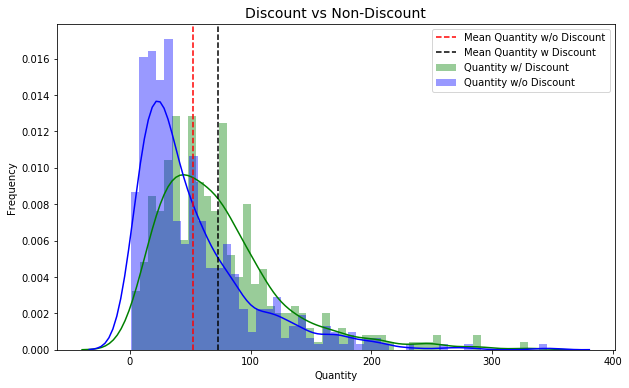

In [20]:
visualization_quantity(a, b)

Discount and Non-Discount distributions do not seem to be normally distributed, however, since the sample size is large enough (>30), we can still use T-Test on sample means based on **Central Limit Theorem**.

The central limit theorem states that if you have a population with mean μ and standard deviation σ and **take sufficiently large random samples** from the population with replacement , then the distribution of the sample means will be approximately normally distributed.

But we still need to test the equality of variance to decide if 2 sample T-Test or Welch's T-Test should be used. 

### 1.3 Hypothesis Test

#### Test of Equal Variance

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test in the case where there are significant deviations from normality.

In [21]:
stats.levene(a, b, center='mean')

LeveneResult(statistic=1.0369358925445291, pvalue=0.30883261672605483)

The Pvalue is 0.3088 > alpha(0.05), so we can not reject the null hypothesis that both samples are from populations with equal variance. Therefore, we can use two sample t test in this case.

#### 2 Sample Independent T-Test

In [22]:
stats.ttest_ind(a, b, equal_var=True)

Ttest_indResult(statistic=-5.91731561103876, pvalue=4.7876655924928625e-09)

#### Mann-Whitney Test

In [23]:
#Non Parametric equivalent of t tests
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=59105.0, pvalue=8.524065415288705e-15)

In [24]:
#Confidence level of 95%
alpha = 0.05

#### Conclusion: Since pvalue is smaller than alpha, we reject the null. There is significant effect on product quantity when discount exists. 

#### Effect Size

In [25]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [26]:
abs(Cohen_d(a,b))

0.4122521666326047

#### Cohen's D shows the difference is small to medium

### Next examine whether impact on quantity volume varies on discount levels

$H_0$: There is **no** significant difference in impact on quantity between discount levels <br>

$H_a$: There is significant difference in impact on quantity between at least one discount levels<br>

Significant level = 95%, alpha = 0.05


In [27]:
discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


Data Exploration

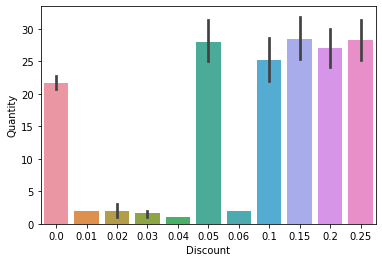

In [28]:
ax = sns.barplot(x="Discount", y="Quantity", data=discount)

Only keep 5%, 10%, 15%, 20%, 25%

**Data Transformation**

In [29]:
discount1 = discount.pivot(columns='Discount',values='Quantity') 

In [30]:
discount1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 11 columns):
0.0     1317 non-null float64
0.01    1 non-null float64
0.02    2 non-null float64
0.03    3 non-null float64
0.04    1 non-null float64
0.05    185 non-null float64
0.06    1 non-null float64
0.1     173 non-null float64
0.15    157 non-null float64
0.2     161 non-null float64
0.25    154 non-null float64
dtypes: float64(11)
memory usage: 202.0 KB


In [31]:
discount2 = discount1.drop(columns={0.01,0.02,0.03,0.04,0.06})

In [32]:
discount2 = discount1.rename(columns={0.0:"A",0.05:"B",0.1:"C",0.15:"D",0.2:"E",0.25:"F"})

In [33]:
discount2.head()

Discount,A,0.01,0.02,0.03,0.04,B,0.06,C,D,E,F
0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
A = discount2['A'].dropna()
B = discount2['B'].dropna()
C = discount2['C'].dropna()
D = discount2['D'].dropna()
E = discount2['E'].dropna()
F = discount2['F'].dropna()

### Test for equality of variances for 5 discount groups

In [35]:
stats.levene(B,C,D,E,F)

LeveneResult(statistic=0.2092544330590371, pvalue=0.9333364288844539)

Since Pvalue > alpha (0.05), we can not reject the null which believes samples are from population with equal variance. We can use ANOVA test.

#### Use stats.f_oneway 

In [36]:
f_stat, p_value = stats.f_oneway(B,C,D,E,F)
print('F-stat:',f_stat)
print('p-value:',p_value)

F-stat: 0.6741032559876151
p-value: 0.610041445360832


#### Use multiple linear regression

In [37]:
df = df_sql(
"""
SELECT * FROM OrderDetail
WHERE Discount IN (0.05, 0.1, 0.15, 0.2, 0.25);

""")

In [38]:
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


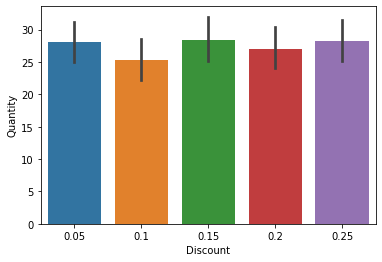

In [39]:
ax = sns.barplot(x='Discount', y='Quantity', data = df)

In [40]:
df['Discount'] = df['Discount'].astype('category')

In [41]:
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


In [42]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [43]:
results = ols('Quantity ~ Discount', data=df).fit()

table = sm.stats.anova_lm(results, typ=1)

print(table)

             df         sum_sq     mean_sq         F    PR(>F)
Discount    4.0    1159.517551  289.879388  0.674103  0.610041
Residual  825.0  354768.342690  430.022234       NaN       NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  0.05    0.1  -2.7738 0.6877 -8.7696  3.222  False
  0.05   0.15   0.3714    0.9 -5.7803  6.523  False
  0.05    0.2   -0.986    0.9 -7.0962 5.1242  False
  0.05   0.25   0.2294    0.9 -5.9546 6.4134  False
   0.1   0.15   3.1452 0.6246 -3.1037  9.394  False
   0.1    0.2   1.7879    0.9 -4.4202 7.9959  False
   0.1   0.25   3.0033 0.6636 -3.2774 9.2839  False
  0.15    0.2  -1.3573    0.9  -7.716 5.0014  False
  0.15   0.25  -0.1419    0.9 -6.5715 6.2877  False
   0.2   0.25   1.2154    0.9 -5.1745 7.6054  False
---------------------------------------------------


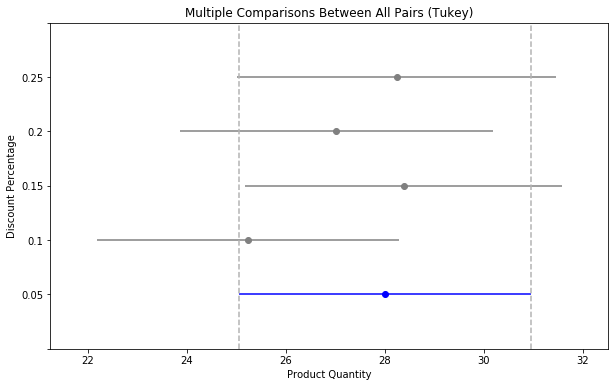

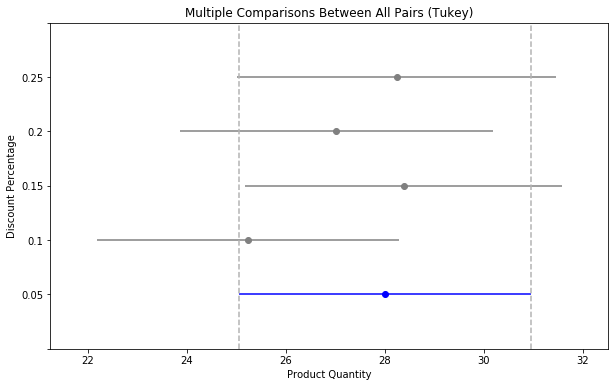

In [44]:
#Do Tukey's after Anova, Tukey makes your alpha even smaller.
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(df['Quantity'],df['Discount'])
tukey = com.tukeyhsd()
print(tukey.summary())
tukey.plot_simultaneous(comparison_name = 0.05, figsize=(10,6), ylabel='Discount Percentage', xlabel='Product Quantity')

### 1.4 Result Intepretation

- There is a significant difference in quantity of products per order between Discount vs Non Discount. When Discount is present, consumers turn to buy more products per order.
- There is no signicant difference in quantity per order among different discount levels which means Northwind can reduce the discount percentage, however increase the discount frequency to get optimal results

## Question 2: Category Performance - How does discount impact category performance?

- If discount has effect on revenue for sepecific categories?

<a id="004"></a>

### 2.1 Hypothesis Statement

$H_0$: Discount does not have impact on the revenue of any category<br>
$H_a$: Discount does have impact on the revenue of one or more categories<br>

Signigicantly level: 95%, alpha = 0.05/8 = 0.0625

**Bonferroni Correction**

The Bonferroni Correction is a multiple-comparison correction used when several dependent or independent statistical tests are being performed simultaneously in order to avoid a lot of spurious positives. The alpha value needs to be lowered to account for the number of comparisons being performed. 

New alpha = alpha/n 

n: number of tests

### 2.2 Data Exploration

In [45]:
product = df_sql(
"""
SELECT * FROM Product

""")

In [46]:
product.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [47]:
#Join Product and Category

category = df_sql("""
SELECT * FROM OrderDetail
""")
category.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


Join OrderDetail, Product, Category

In [48]:
category = df_sql("""


SELECT O.OrderId, P.Id AS ProductId, C.CategoryName, O.UnitPrice, O.Quantity, O.Discount FROM OrderDetail O
JOIN
Product P
ON O.ProductId = P.Id
JOIN Category C
ON P.CategoryId = C.Id

"""
)

In [49]:
category.head()

,OrderId,ProductId,CategoryName,UnitPrice,Quantity,Discount
0,10248,11,Dairy Products,14.0,12,0.0
1,10248,42,Grains/Cereals,9.8,10,0.0
2,10248,72,Dairy Products,34.8,5,0.0
3,10249,14,Produce,18.6,9,0.0
4,10249,51,Produce,42.4,40,0.0


In [50]:
#Calculate line revenue
category['revenue']=category['UnitPrice']*category['Quantity']*(1-category['Discount'])

In [51]:
#Assign Identifier to Discount vs No-Discount

category.loc[(category.Discount != 0), 'Disc_label'] = "Discount"
category.loc[(category.Discount == 0), 'Disc_label'] = "No Discount"


In [52]:
category.head()

,OrderId,ProductId,CategoryName,UnitPrice,Quantity,Discount,revenue,Disc_label
0,10248,11,Dairy Products,14.0,12,0.0,168.0,No Discount
1,10248,42,Grains/Cereals,9.8,10,0.0,98.0,No Discount
2,10248,72,Dairy Products,34.8,5,0.0,174.0,No Discount
3,10249,14,Produce,18.6,9,0.0,167.4,No Discount
4,10249,51,Produce,42.4,40,0.0,1696.0,No Discount


Text(0.5, 1.0, 'Category Sales Quantity Discount vs Non-Discount')

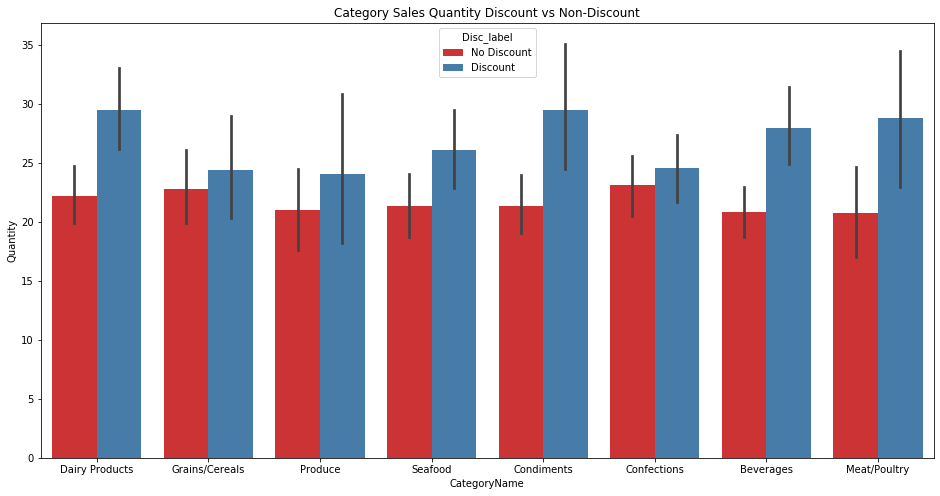

In [53]:
#Plot quantity by category when Discount vs No Discount
plt.figure(figsize=(16,8))
ax = sns.barplot(x='CategoryName', y="Quantity", hue="Disc_label", data=category, palette="Set1")
ax.set_title("Category Sales Quantity Discount vs Non-Discount")

There are observable differeces in quantity in Dairy, Beverages, Meat, Condiments category. 

Text(0.5, 1.0, 'Category Revenue Discount vs Non-Discount')

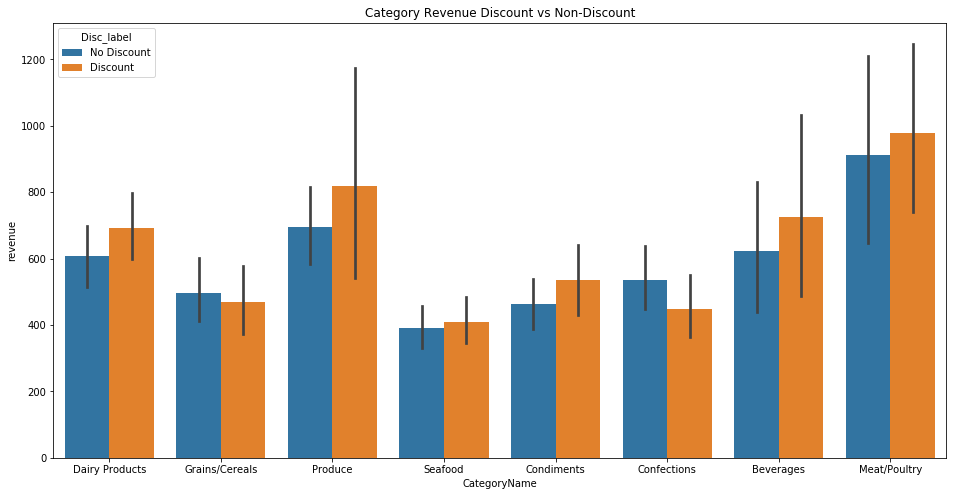

In [54]:
#Plot revenue by category when Discount vs No Discount
plt.figure(figsize=(16,8))
ax = sns.barplot(x='CategoryName', y="revenue", hue="Disc_label", data=category)
ax.set_title("Category Revenue Discount vs Non-Discount")

**Essentially we need 8 T-Tests 

Check sample size of each category

In [55]:
category.pivot_table(values='revenue', index='CategoryName', columns='Disc_label', aggfunc="count")

Disc_label,Discount,No Discount
CategoryName,,
Beverages,158,246
Condiments,85,131
Confections,134,200
Dairy Products,142,224
Grains/Cereals,63,133
Meat/Poultry,76,97
Produce,45,91
Seafood,135,195


All sample groups have sample size of > 25. 

Check average revenue per order by category

In [56]:
category.pivot_table(values='revenue', index='CategoryName', columns='Disc_label', aggfunc="mean")

Disc_label,Discount,No Discount
CategoryName,,
Beverages,726.632468,622.196138
Condiments,534.932765,462.425954
Confections,449.468321,535.642350
Dairy Products,693.448486,607.310714
Grains/Cereals,470.572817,496.981203
Meat/Poultry,979.391441,913.284639
Produce,817.644000,694.402198
Seafood,409.221907,389.829641


Construct test datasets

In [57]:
A = category['Disc_label']=='Discount'
B = category['Disc_label']=='No Discount'

Beverage = category['CategoryName'] == 'Beverages'
Condiments = category['CategoryName'] == 'Condiments'
Confections = category['CategoryName'] == 'Confections'
Dairy = category['CategoryName'] == 'Dairy Products'
Grains = category['CategoryName'] == 'Grains/Cereals'
Meat = category['CategoryName'] == 'Meat/Poultry'
Produce = category['CategoryName'] == 'Produce'
Seafood = category['CategoryName'] == 'Seafood'


In [58]:
beverage_d = category[A][Beverage]['revenue']
beverage_nd = category[B][Beverage]['revenue']

condiment_d = category[A][Condiments]['revenue']
condiment_nd = category[B][Condiments]['revenue']

confection_d = category[A][Confections]['revenue']
confection_nd = category[B][Confections]['revenue']

dairy_d = category[A][Dairy]['revenue']
dairy_nd = category[B][Dairy]['revenue']

grain_d = category[A][Grains]['revenue']
grain_nd = category[B][Grains]['revenue']

meat_d = category[A][Meat]['revenue']
meat_nd = category[B][Meat]['revenue']

produce_d = category[A][Produce]['revenue']
produce_nd = category[B][Produce]['revenue']

seafood_d = category[A][Seafood]['revenue']
seafood_nd = category[B][Seafood]['revenue']

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\Users\bonma1\AppData\Local\Continuum\ana

### 2.3 Hypothesis Test

>#### 1) Discount vs Non-Discount on Beverage Category

In [59]:
def visualization(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Revenue w/ Discount', color='green')
    sns.distplot(control, bins=50,  label='Revenue w/o Discount', color='blue')

    plt.axvline(x=control.mean(), color='r', linestyle='--', label='Mean Revenue w/o Discount')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--', label='Mean Revenue w Discount')

    plt.title('Discount vs Non-Discount', fontsize=14)
    plt.xlabel('Quantity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

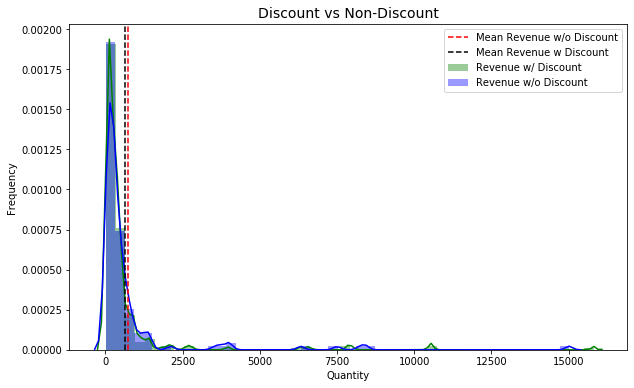

In [60]:
visualization(beverage_d, beverage_nd)

Apparently does not follow normal distribution. Conduct test for equality of variances. 

In [61]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [62]:
variance_test(beverage_d, beverage_nd)

P-value is: 0.4803122812920245


'Fail to reject the null that two samples are from populations that have same variance'

Two sample groups are not from normal distribution, however, they are from populations which have similar variances. We can use Mann-Whitney test in this case. 

**Mann-Whitney T-Test**

In [63]:
mannwhitney_test(beverage_d, beverage_nd)

P-value is 0.10847964805930477


'Fail to reject the null.'

**Conclusion: Fail to reject the null, Discount does not have significant impact on the revenue of Beverage category**

>#### 2) Discount vs Non-Discount on Condiments Category 

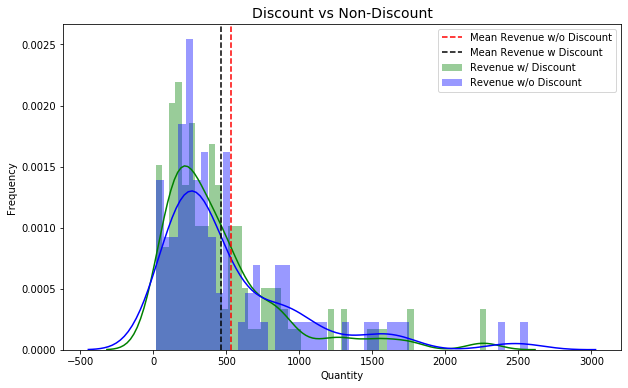

In [64]:
visualization(condiment_d, condiment_nd)

In [65]:
normality_test(condiment_d)

Reject the null. The sample is not normally distributed at the significance level


In [66]:
normality_test(condiment_nd)

Reject the null. The sample is not normally distributed at the significance level


In [67]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [68]:
variance_test(condiment_d, condiment_nd)

P-value is: 0.11385020965436708


'Fail to reject the null that two samples are from populations that have same variance'

Two sample groups are not from normal distribution, however, they are from populations which have similar variances. We can use Mann-Whitney test in this case. 

**Mann-Whitney T-Test**

In [69]:
mannwhitney_test(condiment_d, condiment_nd)

P-value is 0.17235393328834803


'Fail to reject the null.'

**Discount does not have significant impact on the revenue of Condiment category**

>#### 3) Discount vs Non-Discount on Confection Category 

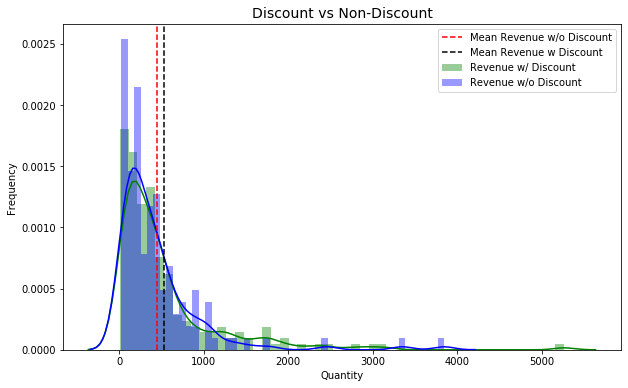

In [70]:
visualization(confection_d, confection_nd)

In [71]:
normality_test(confection_d)

Reject the null. The sample is not normally distributed at the significance level


In [72]:
normality_test(confection_nd)

Reject the null. The sample is not normally distributed at the significance level


In [73]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [74]:
variance_test(confection_d, confection_nd)

P-value is: 0.07295964621863409


'Fail to reject the null that two samples are from populations that have same variance'

Two sample groups are not from normal distribution, however, they are from populations which have similar variances. We can use Mann-Whitney test in this case. 

**Mann-Whitney T-Test**

In [75]:
mannwhitney_test(confection_d, confection_nd)

P-value is 0.19405516425946606


'Fail to reject the null.'

**Discount does not have significant impact on Condiment category**

>#### 4) Discount vs Non-Discount on Dairy Category 

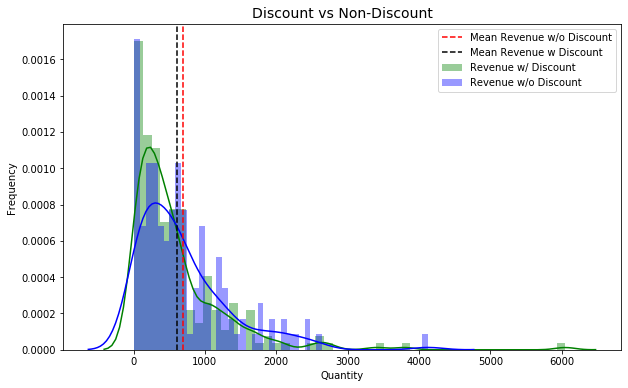

In [76]:
visualization(dairy_d, dairy_nd)

In [77]:
normality_test(dairy_d)

Reject the null. The sample is not normally distributed at the significance level


In [78]:
normality_test(dairy_nd)

Reject the null. The sample is not normally distributed at the significance level


In [79]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [80]:
variance_test(dairy_d, dairy_nd)

P-value is: 0.6883829395413427


'Fail to reject the null that two samples are from populations that have same variance'

Two sample groups are not from normal distribution, however, they are from populations which have similar variances. We can use Mann-Whitney test in this case. 

**Mann-Whitney T-Test**

In [81]:
mannwhitney_test(dairy_d, dairy_nd, alpha = 0.0625)

P-value is 0.0408980627342111


'Reject the null hypothesis.'

**Do not reject the Null hypothesis because the alpha has been adjusted to 0.0625 (Bonferroni Correction)**

#### Check the Effect Size 

In [82]:
Cohen_d(dairy_d, dairy_nd)

0.12459519845056158

Effective Size is < 0.2. The effect is considered small. 

>#### 5) Discount vs Non-Discount on Grain Category

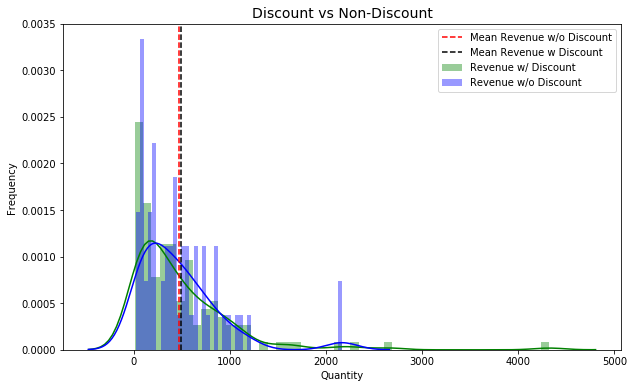

In [83]:
visualization(grain_d, grain_nd)

In [84]:
normality_test(grain_d)

Reject the null. The sample is not normally distributed at the significance level


In [85]:
normality_test(grain_nd)

Reject the null. The sample is not normally distributed at the significance level


In [86]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [87]:
variance_test(grain_d, grain_nd)

P-value is: 0.2370906207093773


'Fail to reject the null that two samples are from populations that have same variance'

Two sample groups are not from normal distribution, however, they are from populations which have similar variances. We can use Mann-Whitney test in this case. 

**Mann-Whitney T-Test**

In [88]:
mannwhitney_test(grain_d, grain_nd)

P-value is 0.33602589469251215


'Fail to reject the null.'

**Conclusion: Fail to reject the null. Discount does not have significant impact on the revenue of Grain category**

>#### 6) Discount vs Non-Discount on Meat Category

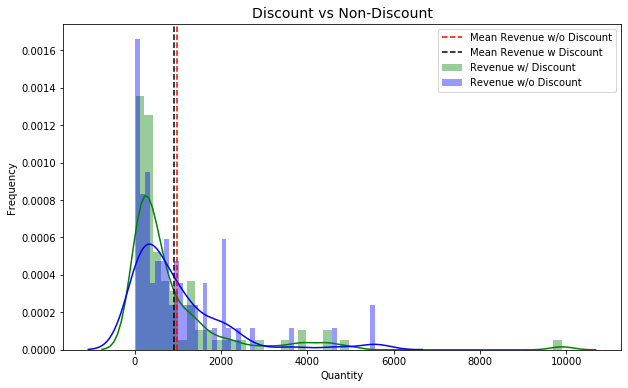

In [89]:
visualization(meat_d, meat_nd)

In [90]:
normality_test(meat_d)

Reject the null. The sample is not normally distributed at the significance level


In [91]:
normality_test(meat_nd)

Reject the null. The sample is not normally distributed at the significance level


In [92]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [93]:
variance_test(meat_d, meat_nd)

P-value is: 0.713667446729404


'Fail to reject the null that two samples are from populations that have same variance'

Two sample groups are not from normal distribution, however, they are from populations which have similar variances. We can use Mann-Whitney test in this case. 

**Mann-Whitney T-Test**

In [94]:
mannwhitney_test(meat_d, meat_nd)

P-value is 0.13843878395739778


'Fail to reject the null.'

**Conclusion: Fail to reject the null. Discount does not have significant impact on the revenue of Meat category**

>#### 7) Discount vs Non-Discount on Produce Category

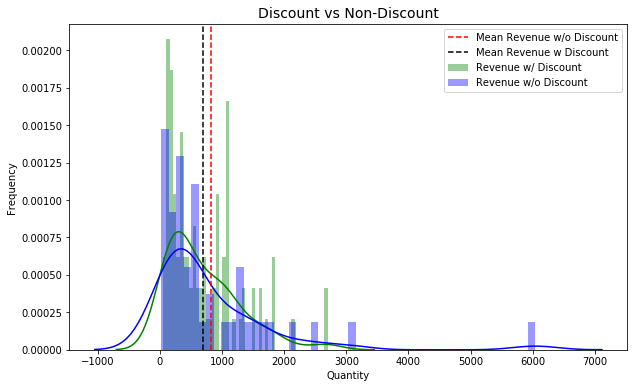

In [95]:
visualization(produce_d, produce_nd)

In [96]:
normality_test(produce_d)

Reject the null. The sample is not normally distributed at the significance level


In [97]:
normality_test(produce_nd)

Reject the null. The sample is not normally distributed at the significance level


In [98]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [99]:
variance_test(produce_d, produce_nd)

P-value is: 0.029443484726860723


'Reject the null. Two samples are from populations that do not have same variance'

Two sample groups are not from normal distribution, neither do they come from populations with same variance. Should use Kolmogorov-Smirnov Test

**Kolmogorov-Smirnov 2 Sample Test**

In [100]:
stats.ks_2samp(produce_d, produce_nd)

Ks_2sampResult(statistic=0.10622710622710622, pvalue=0.8373262961848094)

**Conclusion: Fail to reject the null. Discount does not have significant impact on the revenue of Produce category**

>#### 8) Discount vs Non-Discount on Seafood Category

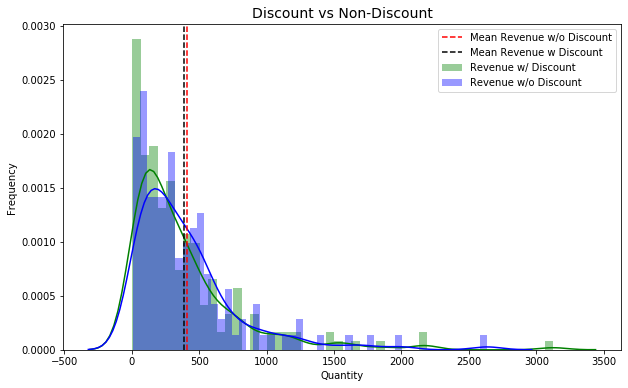

In [101]:
visualization(seafood_d, seafood_nd)

In [102]:
normality_test(seafood_d)

Reject the null. The sample is not normally distributed at the significance level


In [103]:
normality_test(seafood_nd)

Reject the null. The sample is not normally distributed at the significance level


In [104]:
def variance_test(a,b):
    statistic, pvalue = stats.levene(a,b, center='mean')
    print("P-value is: " + str(pvalue))
    if pvalue >= 0.05:
        return "Fail to reject the null that two samples are from populations that have same variance"
    else:
        return "Reject the null. Two samples are from populations that do not have same variance"

In [105]:
variance_test(seafood_d, seafood_nd)

P-value is: 0.6912449511234167


'Fail to reject the null that two samples are from populations that have same variance'

Two sample groups are not from normal distribution, however, they are from two populations that have same variance. 

**Mann-Whitney T-Test**

In [106]:
mannwhitney_test(seafood_d, seafood_nd)

P-value is 0.13473137661940532


'Fail to reject the null.'

**Conclusion: Fail to reject the null. Discount does not have significant impact on the revenue of Seafood category**

## Validate with Two Way Anova

Two way ANOVA is used when examining the influence of two different categorical independent variables on one continuous dependent variable. The two-way ANOVA not only aims at assessing the main effect of each independent variable but also if there is any interaction between them. 

Run two way ANOVA and look at the interaction term.

In [107]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [108]:
category.head()

,OrderId,ProductId,CategoryName,UnitPrice,Quantity,Discount,revenue,Disc_label
0,10248,11,Dairy Products,14.0,12,0.0,168.0,No Discount
1,10248,42,Grains/Cereals,9.8,10,0.0,98.0,No Discount
2,10248,72,Dairy Products,34.8,5,0.0,174.0,No Discount
3,10249,14,Produce,18.6,9,0.0,167.4,No Discount
4,10249,51,Produce,42.4,40,0.0,1696.0,No Discount


> ### a) Discount's impact on Category Revenue

In [109]:
Y = category['revenue']
D = category['Discount']
C = category['CategoryName']

In [110]:
#formula = 'Y ~ C(D) + C(C)'
formula = 'revenue ~ Discount * CategoryName ' #use * to present interaction!
lm = ols(formula, data = category).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                             sum_sq      df         F        PR(>F)
CategoryName           4.634674e+07     7.0  7.179424  1.630021e-08
Discount               3.499535e+04     1.0  0.037947  8.455679e-01
Discount:CategoryName  4.409409e+06     7.0  0.683047  6.865985e-01
Residual               1.972615e+09  2139.0       NaN           NaN


We care the interaction term. However, the pvalue of interaction term is larger than 0.05. 

Let's run Tukey's HSD on interaction term.

Tukey's HSD (honest significant difference) test is used after ANOVA to find where the difference is. It is a post-hoc test. 

In [111]:
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(Y, D.astype("str")+C.astype("str")) #use interaction 
tukey = com.tukeyhsd()
#tukey.plot_simultaneous(comparison_name=, xlabel=, ylabel=)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.01Seafood,0.02Condiments,-5.2,0.9,-5485.5883,5475.1883,False
0.01Seafood,0.02Seafood,5.58,0.9,-5474.8083,5485.9683,False
0.01Seafood,0.03Confections,4.153,0.9,-5476.2353,5484.5413,False
0.01Seafood,0.03Grains/Cereals,34.805,0.9,-5445.5833,5515.1933,False
0.01Seafood,0.03Produce,-7.1475,0.9,-5487.5358,5473.2408,False
0.01Seafood,0.04Confections,48.06,0.9,-5432.3283,5528.4483,False
0.01Seafood,0.05Beverages,1645.9685,0.9,-2303.0716,5595.0086,False
0.01Seafood,0.05Condiments,596.17,0.9,-3379.7216,4572.0616,False
0.01Seafood,0.05Confections,611.6303,0.9,-3329.8374,4553.0979,False
0.01Seafood,0.05Dairy Products,670.4215,0.9,-3252.9395,4593.7825,False


In [112]:
results_summary = tukey.summary()

In [113]:
results_as_html = results_summary.as_html()
result = pd.read_html(results_as_html, header=0)[0]
result.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.01Seafood,0.02Condiments,-5.2000,0.9,-5485.5883,5475.1883,False
1,0.01Seafood,0.02Seafood,5.5800,0.9,-5474.8083,5485.9683,False
2,0.01Seafood,0.03Confections,4.1530,0.9,-5476.2353,5484.5413,False
3,0.01Seafood,0.03Grains/Cereals,34.8050,0.9,-5445.5833,5515.1933,False
4,0.01Seafood,0.03Produce,-7.1475,0.9,-5487.5358,5473.2408,False


In [114]:
#Find pairs with significant mean differences

result[result['reject']==True]

,group1,group2,meandiff,p-adj,lower,upper,reject
370,0.05Beverages,0.05Seafood,-1308.1829,0.0012,-2382.9755,-233.3903,True
372,0.05Beverages,0.0Beverages,-1053.4723,0.0010,-1852.6191,-254.3255,True
373,0.05Beverages,0.0Condiments,-1213.2425,0.0010,-2045.2435,-381.2415,True
374,0.05Beverages,0.0Confections,-1140.0261,0.0010,-1947.9099,-332.1423,True
375,0.05Beverages,0.0Dairy Products,-1068.3577,0.0010,-1871.2470,-265.4685,True
376,0.05Beverages,0.0Grains/Cereals,-1178.6873,0.0010,-2009.6516,-347.7229,True
378,0.05Beverages,0.0Produce,-981.2663,0.0052,-1843.0175,-119.5151,True
379,0.05Beverages,0.0Seafood,-1285.8388,0.0010,-2094.9133,-476.7644,True
380,0.05Beverages,0.15Beverages,-1317.6130,0.0010,-2314.9784,-320.2477,True
382,0.05Beverages,0.15Confections,-1143.4764,0.0117,-2190.1036,-96.8492,True


From the result, we can see that Discount has the most impact on Beverage category. Consumers' spend on beverages varied across different discount level. 

> ### b) Discount's impact on Category quantity

In [115]:
Q = category['Quantity']
D = category['Discount']
C = category['CategoryName']

In [116]:
#formula = 'Y ~ C(D) + C(C)'
formula = 'Quantity ~ Discount * CategoryName ' #use * to present interaction!
lm = ols(formula, data = category).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)


                              sum_sq      df          F        PR(>F)
CategoryName             1270.186154     7.0   0.509027  8.283598e-01
Discount                12862.798249     1.0  36.083352  2.215819e-09
Discount:CategoryName    2745.297952     7.0   1.100178  3.601253e-01
Residual               762499.162909  2139.0        NaN           NaN


We care the interaction term. However, the pvalue of interaction term is larger than 0.05. 

Let's run Tukey's HSD on interaction term

In [117]:
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(Q, D.astype("str")+C.astype("str")) #use interaction 
tukey = com.tukeyhsd()
#tukey.plot_simultaneous(comparison_name=, xlabel=, ylabel=)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.01Seafood,0.02Condiments,-1.0,0.9,-108.2694,106.2694,False
0.01Seafood,0.02Seafood,1.0,0.9,-106.2694,108.2694,False
0.01Seafood,0.03Confections,0.0,0.9,-107.2694,107.2694,False
0.01Seafood,0.03Grains/Cereals,0.0,0.9,-107.2694,107.2694,False
0.01Seafood,0.03Produce,-1.0,0.9,-108.2694,106.2694,False
0.01Seafood,0.04Confections,-1.0,0.9,-108.2694,106.2694,False
0.01Seafood,0.05Beverages,32.5385,0.9,-44.7574,109.8343,False
0.01Seafood,0.05Condiments,35.8421,0.9,-41.9793,113.6635,False
0.01Seafood,0.05Confections,25.4138,0.9,-51.7338,102.5614,False
0.01Seafood,0.05Dairy Products,26.95,0.9,-49.8432,103.7432,False


In [118]:
results_summary = tukey.summary()

In [120]:
result[result['reject']==True]

,group1,group2,meandiff,p-adj,lower,upper,reject


In [119]:
results_as_html = results_summary.as_html()
result = pd.read_html(results_as_html, header=0)[0]
result.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.01Seafood,0.02Condiments,-1.0,0.9,-108.2694,106.2694,False
1,0.01Seafood,0.02Seafood,1.0,0.9,-106.2694,108.2694,False
2,0.01Seafood,0.03Confections,0.0,0.9,-107.2694,107.2694,False
3,0.01Seafood,0.03Grains/Cereals,0.0,0.9,-107.2694,107.2694,False
4,0.01Seafood,0.03Produce,-1.0,0.9,-108.2694,106.2694,False


### 2.5 Results Interpretation

Result of Question 1 shows that Discount does have impact on quantities of products per order. That is definitely one of the top reasons why business is doing discount. However, we also want to understand whether discount makes consumer to spend more per category, it seems only Dairy category generates higher revenue when Discount is present.

<br>However, when looking at different levels of discount, consumers spend more money on Beverage category when a Discount level is higher than 5%. 



## Question 3: Region Performance - Does each region generate same average order revenue?
<a id="005"></a>

### 3.1 Hypothesis Development

$H_0$: The average revenue per order is **NOT** different across regions<br>

$H_a$: The average revenue per order **IS** different across regions<br>

Significant level = 95%, alpha = 0.05

### 3.2 Data Exploration

Join Order and OrderDetail to get total revenue from all regions

In [121]:
customer = df_sql(
"""
SELECT * FROM Customer

       """)

In [122]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      90 non-null object
Country         91 non-null object
Phone           91 non-null object
Fax             69 non-null object
dtypes: object(11)
memory usage: 7.9+ KB


In [123]:
df = df_sql(
"""
SELECT A.OrderId, A.CustomerId, A.Region, SUM(A.Revenue) as OrderRevenue
FROM

(SELECT O.Id AS OrderId,O.CustomerID, C.Region, D.UnitPrice, D.Quantity, D.Discount, (D.Quantity * D.UnitPrice * (1-D.Discount)) AS Revenue  FROM Customer C
JOIN 'Order' O
ON C.ID = O.CustomerId
JOIN OrderDetail D
ON D.OrderId = O.Id) A

GROUP BY A.OrderId

       """)

In [124]:
df.head()

,OrderId,CustomerID,Region,OrderRevenue
0,10248,VINET,Western Europe,440.00
1,10249,TOMSP,Western Europe,1863.40
2,10250,HANAR,South America,1552.60
3,10251,VICTE,Western Europe,654.06
4,10252,SUPRD,Western Europe,3597.90


In [125]:
df.groupby('Region')['OrderId'].count()

Region
British Isles       75
Central America     21
Eastern Europe       7
North America      152
Northern Europe     55
Scandinavia         28
South America      127
Southern Europe     64
Western Europe     272
Name: OrderId, dtype: int64

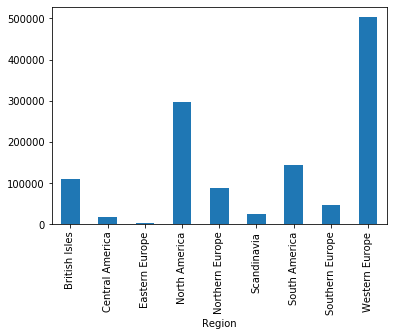

In [126]:
df.groupby('Region')['OrderRevenue'].sum().plot.bar()

In [127]:
df.groupby('Region')['OrderRevenue'].agg(['min','max','sum','mean'])

,min,max,sum,mean
Region,,,,
British Isles,45.00,10835.24,108951.2150,1452.682867
Central America,88.80,4150.05,16558.1000,788.480952
Eastern Europe,160.00,808.00,3531.9500,504.564286
North America,36.00,12615.05,295780.9005,1945.926977
Northern Europe,48.75,11188.40,87156.1625,1584.657500
Scandinavia,120.00,2684.40,24545.2025,876.614375
South America,12.50,15810.00,142677.8080,1123.447307
Southern Europe,18.40,3026.85,45225.7175,706.651836
Western Europe,28.00,16387.50,503548.4085,1851.280914


Text(0.5, 0, 'Revenue ($)')

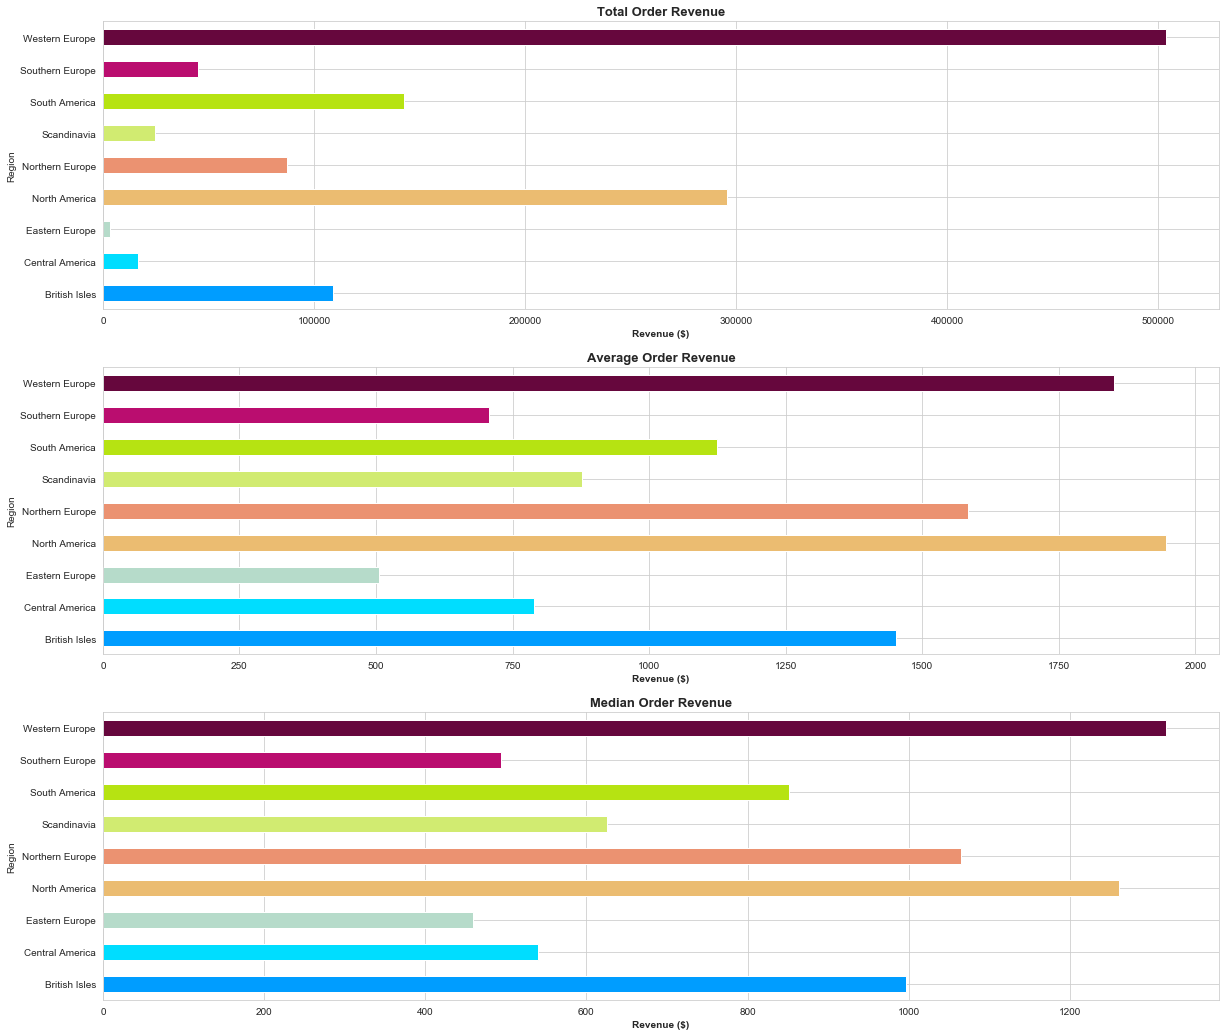

In [128]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(3,1, figsize=(20,18))
color1=['#009dff', '#00ddff', '#b6dbca','#ebbc71','#eb9271', '#d1eb71', '#b6e312', '#ba0d6f', '#66073d']

df.groupby('Region')['OrderRevenue'].sum().plot(kind='barh', ax = axes[0], color=color1)
df.groupby('Region')['OrderRevenue'].mean().plot(kind='barh', ax = axes[1], color=color1)
df.groupby('Region')['OrderRevenue'].median().plot(kind='barh', ax = axes[2], color=color1)

# Subplot 1 Labels:
axes[0].set_title('Total Order Revenue', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Revenue ($)', fontweight='semibold')

#Subplot 2 Labels:
axes[1].set_title('Average Order Revenue', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Revenue ($)', fontweight='semibold')

#Subplot 2 Labels:
axes[2].set_title('Median Order Revenue', fontweight='bold', fontsize=13)
axes[2].set_xlabel('Revenue ($)', fontweight='semibold')


9 Regions have quite different total revenue at a glance with Western Europe being the top driver, following by North America. However, some regions have close average revenue per customer such as Western Europe and North America. Looking at avg revenue per customer helps the company evalute types of business in the region: Small - Meidum Business vs Enterprise

In [129]:
#Number of Customers by Region 
df.groupby('Region')['CustomerID'].count()

Region
British Isles       75
Central America     21
Eastern Europe       7
North America      152
Northern Europe     55
Scandinavia         28
South America      127
Southern Europe     64
Western Europe     272
Name: CustomerID, dtype: int64

**Two ways of looking at regions**
- Divide 9 regions to 5 bigger regions: Western & Eastern Europe; Northern & Southern Europe; British Isles & Scandinavia; North America; Central & South America
- Divide 9 regions to 2 parts: Europe, Americas

In [130]:
df.head()

,OrderId,CustomerID,Region,OrderRevenue
0,10248,VINET,Western Europe,440.00
1,10249,TOMSP,Western Europe,1863.40
2,10250,HANAR,South America,1552.60
3,10251,VICTE,Western Europe,654.06
4,10252,SUPRD,Western Europe,3597.90


In [131]:
df.loc[(df.Region == 'Western Europe') | (df.Region == 'Eastern Europe'), 'NewRegion'] = 'W & E Europe'
df.loc[(df.Region == 'Northern Europe') | (df.Region == 'Southern Europe'), 'NewRegion'] = 'N & S Europe'
df.loc[(df.Region == 'British Isles') | (df.Region == 'Scandinavia'), 'NewRegion'] = 'British Isles & Scandinavia'
df.loc[df.Region == 'North America' , 'NewRegion'] = 'North America'
df.loc[(df.Region == 'Central America') | (df.Region == 'South America'), 'NewRegion'] = 'C & S America'

In [132]:
df.loc[(df.NewRegion == 'W & E Europe') | (df.NewRegion == 'N & S Europe') | (df.NewRegion == 'British Isles & Scandinavia'), 'Area'] = 'Europe'
df.loc[(df.NewRegion == 'North America') | (df.NewRegion == 'C & S America'), 'Area'] = 'Americas'

In [133]:
df.groupby('Region')['NewRegion'].count()

Region
British Isles       75
Central America     21
Eastern Europe       7
North America      152
Northern Europe     55
Scandinavia         28
South America      127
Southern Europe     64
Western Europe     272
Name: NewRegion, dtype: int64

In [134]:
df.groupby('NewRegion')['OrderRevenue'].agg(['min','max','sum','mean','count'])

,min,max,sum,mean,count
NewRegion,,,,,
British Isles & Scandinavia,45.0,10835.24,133496.4175,1296.081723,103
C & S America,12.5,15810.00,159235.9080,1075.918297,148
N & S Europe,18.4,11188.40,132381.8800,1112.452773,119
North America,36.0,12615.05,295780.9005,1945.926977,152
W & E Europe,28.0,16387.50,507080.3585,1817.492324,279


In [135]:
sub_df = df[['NewRegion','OrderRevenue']]

### 3.3 Hypothesis Test

In [136]:
#Construct Test datasets: W&E Europe - E1, N&S Europe - E2, British & Scandinavia - E3, North America - A1, C&S America - A2
E1 = sub_df[sub_df['NewRegion']=='W & E Europe']['OrderRevenue']
E2 = sub_df[sub_df['NewRegion']=='N & S Europe']['OrderRevenue']
E3 = sub_df[sub_df['NewRegion']=='British Isles & Scandinavia']['OrderRevenue']
A1 = sub_df[sub_df['NewRegion']=='North America']['OrderRevenue']
A2 = sub_df[sub_df['NewRegion']=='C & S America']['OrderRevenue']

Text(0.5, 1.0, 'Distribution of Revenue by Region')

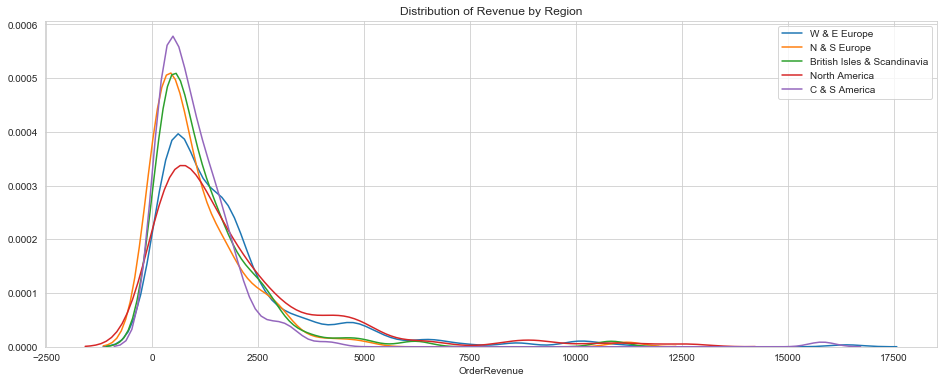

In [137]:
#Plot the distributions of 5 regions

plt.figure(figsize=(16,6))
ax = sns.distplot(E1, hist=False, label='W & E Europe')
ax = sns.distplot(E2, hist=False, label='N & S Europe')
ax = sns.distplot(E3, hist=False, label='British Isles & Scandinavia')
ax = sns.distplot(A1, hist=False, label='North America')
ax = sns.distplot(A2, hist=False, label='C & S America')
plt.title('Distribution of Revenue by Region')

Not normally distributed. However, the sample size is large enough. 

### Test of Equal Variance

Perform Levene test for equal variances.

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality.

In [138]:
stats.levene(E1,E2,E3,A1,A2, center='mean')

LeveneResult(statistic=8.57499006538664, pvalue=8.901192485232916e-07)

The Pvalue is < alpha(0.05), so we can reject the null hypothesis that both samples are from populations with equal variance. Therefore, we have to use non-parametric Krusal-Wallis Test 

### Krusal-Wallis Test

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post-hoc comparisons between groups are required to determine which groups are different.

In [139]:
stats.kruskal(E1, E2, E3, A1, A2)

KruskalResult(statistic=36.797653501198766, pvalue=1.9827434923176663e-07)

P-value is < alpha (0.05), therefore we can reject the null. There is significant difference in the average revenue in 5 regions. 

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles & Scandinavia,C & S America,-220.1634,0.87,-858.4592,418.1323,False
British Isles & Scandinavia,N & S Europe,-183.629,0.9,-853.0802,485.8223,False
British Isles & Scandinavia,North America,649.8453,0.0419,15.0053,1284.6852,True
British Isles & Scandinavia,W & E Europe,521.4106,0.0948,-52.1054,1094.9266,False
C & S America,N & S Europe,36.5345,0.9,-575.937,649.0059,False
C & S America,North America,870.0087,0.001,295.5715,1444.4459,True
C & S America,W & E Europe,741.574,0.001,235.7313,1247.4168,True
N & S Europe,North America,833.4742,0.0018,224.6051,1442.3433,True
N & S Europe,W & E Europe,705.0396,0.0039,160.4109,1249.6682,True
North America,W & E Europe,-128.4347,0.9,-629.9097,373.0404,False


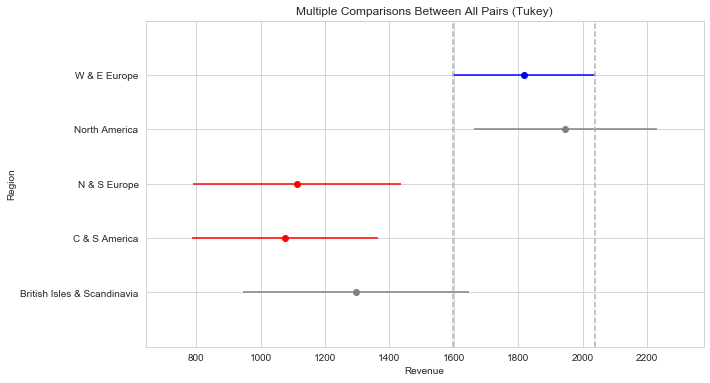

In [140]:
#Tukey's HSD post-hoc comparisons
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(df['OrderRevenue'], df['NewRegion'])
tukey = com.tukeyhsd()
tukey.plot_simultaneous(comparison_name='W & E Europe', xlabel='Revenue', ylabel='Region')
tukey.summary()


plot_intervals will color code all groups that are significantly different from the comparison_name red, and will color code insignificant groups gray. Otherwise, all intervals will just be plotted in black.

Conclusion: The average order revenue of 5 regions are not all the same. 5 regions can be classified to three groups and within groups, there are more similarity. North America and Western & Eastern Europe are in Group A;Northern & Southern Europe, Central & Southern America are in Group C,  British Isles & Scandinavia is in Group B. Group A generate significantly more revenue than Group C, while Group B is in the middle of Group A and C. 

### 3.4 Result Interpretation

There is no significant difference within a group, however, there is significant difference across groups. Group A > Group B > Group C. Since Group A is the best performing region, Northwind should make sure Group A get enough resources and support from the operation. 


## Question 4: Does seasonality have a significant impact on the revenue of any category in an order?

- Which category have better revenue during summer? (July & August)
- Which category have better revenue during winter? (December & January)
<a id="006"></a>

### 4.1 Hypothesis Statement

$H_0$: The average revenue per order is **NOT** impacted by seasonality<br>

$H_a$: The average revenue per order **IS** impacted by seasonality <br>

Significant level = 95%, alpha = 0.05

### 4.2 Data Exploration

In [141]:
#Join Product and Category

category = df_sql("""
SELECT * FROM "Order"
""")
category.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


Join Order, OrderDetail, Product, Category

In [142]:
season = df_sql("""


SELECT D.OrderId, O.OrderDate, P.Id AS ProductId, C.CategoryName, O.ShipRegion, D.UnitPrice, D.Quantity, D.Discount FROM "Order" O
JOIN OrderDetail D
ON O.Id = D.OrderId
JOIN
Product P
ON D.ProductId = P.Id
JOIN Category C
ON P.CategoryId = C.Id

"""
)

In [143]:
season.head()

,OrderId,OrderDate,ProductId,CategoryName,ShipRegion,UnitPrice,Quantity,Discount
0,10248,2012-07-04,11,Dairy Products,Western Europe,14.0,12,0.0
1,10248,2012-07-04,42,Grains/Cereals,Western Europe,9.8,10,0.0
2,10248,2012-07-04,72,Dairy Products,Western Europe,34.8,5,0.0
3,10249,2012-07-05,14,Produce,Western Europe,18.6,9,0.0
4,10249,2012-07-05,51,Produce,Western Europe,42.4,40,0.0


In [144]:
season['Revenue']=season['UnitPrice']*season['Quantity']*(1-season['Discount'])

In [145]:
from datetime import datetime

season['OrderDate']=pd.to_datetime(season['OrderDate'])

In [146]:
season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 9 columns):
OrderId         2155 non-null int64
OrderDate       2155 non-null datetime64[ns]
ProductId       2155 non-null int64
CategoryName    2155 non-null object
ShipRegion      2155 non-null object
UnitPrice       2155 non-null float64
Quantity        2155 non-null int64
Discount        2155 non-null float64
Revenue         2155 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 151.6+ KB


In [147]:
season['ShipRegion'].unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

#### Seasonal Decomposition

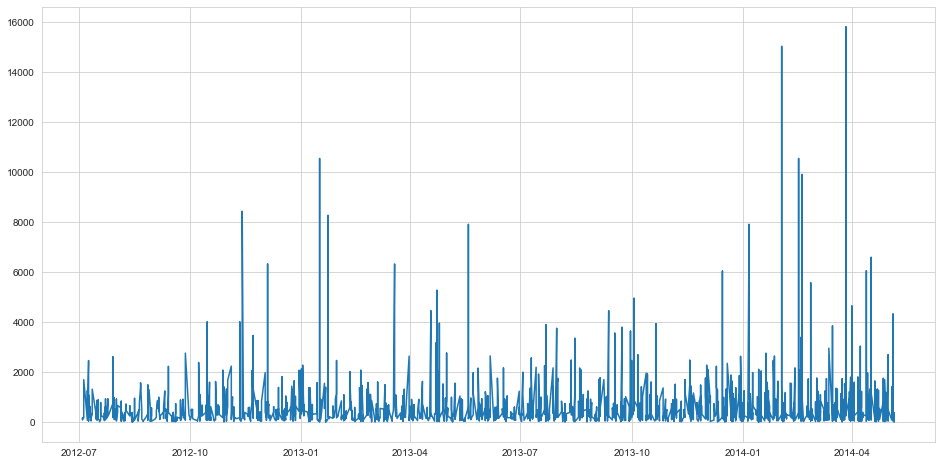

In [148]:
plt.figure(figsize=[16,8])
plt.plot('OrderDate','Revenue', data=season)

The data ranges from July 2012 to April 2014. 

Seasonality depends on region and country. Except for South America and Central America (tropical), all other 7 regions are in Northern Hemisphere. To answer this question, we can make the following generalization:

<blockquote>
<ul>
<li>Summer sales season for Western Europe, North America, Northern Europe, Scandinavia, Southern Europe, British Isles, Eastern Europe: July and August </li>
<li>Winter sales season for Western Europe, North America, Northern Europe, Scandinavia, Southern Europe, British Isles, Eastern Europe: December and January </li>
<li>Summer sales season for South America and Central America: December and January </li>
    <li>Summer sales season for South America and Central America: July and August </li>
</blockquote>

In [149]:
season['month']=season['OrderDate'].dt.month

In [150]:
season.loc[(season['month']==7) | (season['month']==8),'Season']='Summer'
season.loc[(season['month']==1) | (season['month']==12),'Season']='Winter'


In [151]:
season = season.fillna(value = 'Normal')

In [152]:
season['Season'].unique()

array(['Summer', 'Normal', 'Winter'], dtype=object)

**Let's first look at Northern Hemisphere**

In [153]:
NH = season[(season['ShipRegion']!='South America') & (season['ShipRegion']!='Central America')]
SH = season[(season['ShipRegion']=='South America') | (season['ShipRegion']=='Central America')]

In [154]:
NH.groupby('ShipRegion')['Revenue'].sum()

ShipRegion
British Isles      108951.2150
Eastern Europe       3531.9500
North America      295780.9005
Northern Europe     87156.1625
Scandinavia         24545.2025
Southern Europe     45225.7175
Western Europe     505164.3085
Name: Revenue, dtype: float64

In [155]:
SH.groupby('ShipRegion')['Revenue'].sum()

ShipRegion
Central America     23582.0775
South America      171855.5055
Name: Revenue, dtype: float64

### 4.3 Hypothesis Test

#### Test for equality of variance

> 1) Northern Hemisphere

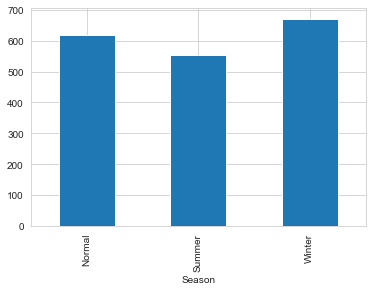

In [156]:
#Northern Hemisphere Revenue by Season
NH.groupby('Season')['Revenue'].mean().plot(kind='bar')

In [157]:
normal = NH[NH['Season']=='Normal']['Revenue']
summer = NH[NH['Season']=='Summer']['Revenue']
winter = NH[NH['Season']=='Winter']['Revenue']

Sample size is large enough to satisfy Central Limit Theorem. Test for variance.

In [158]:
stats.levene(normal, summer, winter, center='mean')

LeveneResult(statistic=1.5216652924924923, pvalue=0.21864091105107436)

P value is larger than 0.05. Do not reject the null. Samples are from the population with same variance. We can use ANOVA in this test.

In [159]:
NH.head()

,OrderId,OrderDate,ProductId,CategoryName,ShipRegion,UnitPrice,Quantity,Discount,Revenue,month,Season
0,10248,2012-07-04,11,Dairy Products,Western Europe,14.0,12,0.0,168.0,7,Summer
1,10248,2012-07-04,42,Grains/Cereals,Western Europe,9.8,10,0.0,98.0,7,Summer
2,10248,2012-07-04,72,Dairy Products,Western Europe,34.8,5,0.0,174.0,7,Summer
3,10249,2012-07-05,14,Produce,Western Europe,18.6,9,0.0,167.4,7,Summer
4,10249,2012-07-05,51,Produce,Western Europe,42.4,40,0.0,1696.0,7,Summer


**Two way ANOVA Test**



In [160]:
formula = 'Revenue ~ Season * CategoryName'
lm = ols(formula, data = NH).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                           sum_sq      df         F        PR(>F)
Season               1.741104e+06     2.0  0.926621  3.960884e-01
CategoryName         4.283717e+07     7.0  6.513739  1.329840e-07
Season:CategoryName  1.511040e+07    14.0  1.148829  3.094539e-01
Residual             1.600892e+09  1704.0       NaN           NaN


P-value for Season * CategoryName is larger than 0.05. Run Tukey's HSD. 

**Tukey's HSD**

In [161]:
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

com = MultiComparison(NH['Revenue'], NH['CategoryName'].astype("str")+ NH['Season'].astype("str")) #use interaction 
tukey = com.tukeyhsd()
#tukey.plot_simultaneous(comparison_name=, xlabel=, ylabel=)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
BeveragesNormal,BeveragesSummer,-288.1923,0.9,-857.3183,280.9337,False
BeveragesNormal,BeveragesWinter,360.4984,0.6515,-166.1432,887.1399,False
BeveragesNormal,CondimentsNormal,-143.4521,0.9,-538.4028,251.4986,False
BeveragesNormal,CondimentsSummer,-121.7498,0.9,-929.4849,685.9852,False
BeveragesNormal,CondimentsWinter,-79.7211,0.9,-826.3231,666.8809,False
BeveragesNormal,ConfectionsNormal,-124.3605,0.9,-483.544,234.823,False
BeveragesNormal,ConfectionsSummer,-2.0796,0.9,-701.0831,696.9239,False
BeveragesNormal,ConfectionsWinter,-134.2965,0.9,-650.447,381.854,False
BeveragesNormal,Dairy ProductsNormal,48.1749,0.9,-303.7457,400.0955,False
BeveragesNormal,Dairy ProductsSummer,-60.3755,0.9,-656.6087,535.8576,False


In [162]:
results_summary = tukey.summary()

In [163]:
results_as_html = results_summary.as_html()
result = pd.read_html(results_as_html, header=0)[0]
result.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,BeveragesNormal,BeveragesSummer,-288.1923,0.9000,-857.3183,280.9337,False
1,BeveragesNormal,BeveragesWinter,360.4984,0.6515,-166.1432,887.1399,False
2,BeveragesNormal,CondimentsNormal,-143.4521,0.9000,-538.4028,251.4986,False
3,BeveragesNormal,CondimentsSummer,-121.7498,0.9000,-929.4849,685.9852,False
4,BeveragesNormal,CondimentsWinter,-79.7211,0.9000,-826.3231,666.8809,False


In [164]:
result[result['reject']==True]

,group1,group2,meandiff,p-adj,lower,upper,reject
14,BeveragesNormal,Meat/PoultryNormal,443.6377,0.0350,12.5776,874.6978,True
36,BeveragesSummer,Meat/PoultryNormal,731.8300,0.0051,105.2414,1358.4186,True
63,BeveragesWinter,SeafoodNormal,-627.5125,0.0049,-1163.5391,-91.4860,True
77,CondimentsNormal,Meat/PoultryNormal,587.0898,0.0017,113.0698,1061.1098,True
131,ConfectionsNormal,Meat/PoultryNormal,567.9982,0.0010,123.3392,1012.6573,True
212,Grains/CerealsNormal,Meat/PoultryNormal,606.0492,0.0016,117.5677,1094.5306,True
245,Meat/PoultryNormal,SeafoodNormal,-710.6519,0.0010,-1153.1289,-268.1748,True
247,Meat/PoultryNormal,SeafoodWinter,-677.4623,0.0177,-1304.0509,-50.8737,True


There is no indication of reject the null within the same category which means that seasonality does not impact category sales. 

> 2) Southern Hemisphere

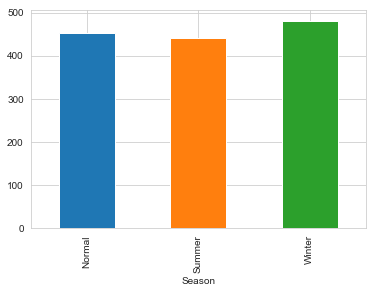

In [564]:
#Southern Hemishpere Revenue by Season
SH.groupby('Season')['Revenue'].mean().plot(kind='bar')

In [565]:
normal = SH[SH['Season']=='Normal']['Revenue']
winter = SH[SH['Season']=='Summer']['Revenue']
summer = SH[SH['Season']=='Winter']['Revenue']

Sample size is large enough to satisfy Central Limit Theorem. Test for variance.

In [566]:
stats.levene(normal, summer, winter, center='mean')

LeveneResult(statistic=0.12753112620727305, pvalue=0.8802997692432568)

P value is larger than 0.05. Do not reject the null. Samples are from the population with same variance. We can use ANOVA in this test.

**Two way ANOVA Test**

Assumption: consumer's consumption in each season is independent

In [567]:
formula = 'Revenue ~ Season*CategoryName'
lm = ols(formula, data = SH).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                           sum_sq     df         F    PR(>F)
Season               6.299396e+04    2.0  0.037038  0.963642
CategoryName         5.801723e+06    7.0  0.974637  0.449228
Season:CategoryName  5.238405e+06   14.0  0.440002  0.961084
Residual             3.427057e+08  403.0       NaN       NaN


P value is larger than 0.05. Do not reject the null. 

### 4.4 Result Interpretation

There is no significant difference in average order revenue in different seasons. Seasonality seems to have no significant impact on AOV of any category. Next step: Specify seasonality or sales season for each region and run similar tests

## 5. Summary
<a id="007"></a>

Based on the analysis above, we can draw below conclusions:
    
- The presence of Discount leads consumers to buy more quantity per order no matter what levels of discount
- The presence of Discount drives higher revenue for Dairy category
- When there is a Discount and the Discount level is above 5%, consumers tend to spend more on Beverage category
- Not all regions have the same scale of revenue. They can be managed in tiers (small, medium and large)
- Seasonality does not have a significant impact on average order revenue

### Next Steps:

- Test different discount mix and find the optimal point between sales volume and profit
- Deep dive into the performance (profit, logistic, marketing, etc.) of the larger region groups and make sure resources are optimized 
- Specify seasonality or sales season for each region and run similar tests
